In [1]:
import os, sys

recsys_cf = os.environ.get("RECSYS_STORY")
sys.path.append(recsys_cf)
os.chdir(recsys_cf)

from lib.tools import *

###### SPARK 

In [2]:
sp = spark(**SPARK_CONFIG)
hive = sp.sql

###### load tables 

In [3]:
%%time
clickstream = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_CLICKSTREAM, hive)

CPU times: user 8.53 ms, sys: 16.5 ms, total: 25.1 ms
Wall time: 1min 3s


In [4]:
clickstream.show(2)

,inn,timestamp,hitPagePath,hitPageTitle,eventCategory,eventAction,eventLabel,product
0,470707811305,1623239609,/accounts-payments,СберБизнес,[std]: payments,click,[ruble_payment_edit]: [action.save],
1,6220008542,1623318711,/main,СберБизнес,[std]: main,click,"[layout.headergeneralsbbol3]: [open burger, novelty: true]",


In [5]:
%%time
user_dict = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_USER_DICT, hive)

CPU times: user 713 µs, sys: 2.42 ms, total: 3.13 ms
Wall time: 49.7 ms


In [6]:
%%time
item_dict = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_ITEM_DICT, hive)

CPU times: user 282 µs, sys: 2.61 ms, total: 2.89 ms
Wall time: 57.3 ms


###### user_id 

In [7]:
clickstream_user = clickstream.join(user_dict, on="inn", how="inner")

In [8]:
clickstream_user.count()

107163853

###### item_user 

In [9]:
na_dict = {"product": "<None>",  "eventCategory": "<None>"}
visit_user_item = clickstream_user.na.fill(na_dict) \
                                  .join(item_dict.na.fill(na_dict), 
                                        on=["eventAction", "eventCategory", "hitPagePath", "product"], 
                                        how="inner") \
                                  .withColumn("product", f.regexp_replace("product", "<None>", None)) \
                                  .withColumn("hitPagePath", f.regexp_replace("hitPagePath", "<None>", None))\
                                  .withColumn("eventCategory", f.regexp_replace("eventCategory", "<None>", None))

In [10]:
visit_user_item.count()

107163853

###### статка 

Number of unique items: 16306


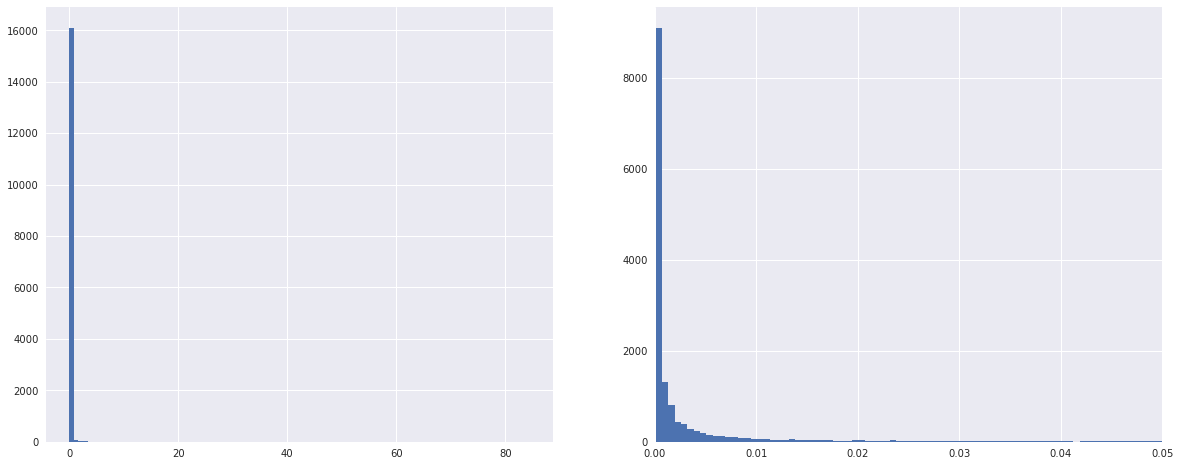

In [11]:
%matplotlib inline

item_pd_percent = item_dict.select("item_user_percent").toPandas().item_user_percent

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.hist(item_pd_percent, bins=100)

plt.subplot(1, 2, 2), plt.xlim((0, 0.05))
plt.hist(item_pd_percent[item_pd_percent < 0.05], bins=80)

print("Number of unique items: {}".format(item_dict.count()))

In [12]:
us_num = visit_user_item.select("inn").distinct().count()

###### фильтрация событий по редкости 


In [13]:
us_num * 0.01 / 100

103.86059999999999

In [14]:
percent_l, percent_r = 0.01, 30

In [15]:
cond = (
            (f.col("item_user_percent") <= percent_r) &
            (f.col("item_user_percent") >= percent_l) 
       )

In [16]:
item_dict_filt = item_dict.filter(cond)

Все продукты, которые остались после фильтрации

In [17]:
item_dict_filt.filter("product <> ''").orderBy(f.col("item_user_percent").desc())\
              .select("product", "item_user_percent", "item_user_count")\
              .distinct()\
              .filter(cond)\
              .show(3)

,product,item_user_percent,item_user_count
0,none,2.89339,30051
1,e-acquiring,0.52012,5402
2,kredit,0.50096,5203


In [18]:
all_events = item_dict_filt.select("item_id").distinct().count()
products = item_dict_filt.select("prod_id").distinct().count()
producted_events = item_dict_filt.select("prod_id").count()
events_without_prod = item_dict_filt.filter("prod_id is Null").select("item_id").distinct().count()

print("All events: {}\nprods: {}\n\t with prouded events: {}\nEvents without prods: {}" \
      .format(all_events, products, producted_events, events_without_prod))

All events: 2307
prods: 63
	 with prouded events: 2729
Events without prods: 2245


###### Фильтрация кликстрима 

In [19]:
visit_user_item_filt = visit_user_item.filter(cond)

visit_user_item_filt.cache()
visit_user_item_filt.count()

44705821

Исключение повторяющихся в кликстриме эвентов

In [20]:
visit_user_item_filt_unique = visit_user_item_filt.groupBy("user_id", "item_id")\
                                                    .agg(f.min("timestamp").alias("timestamp"))
visit_user_item_filt_unique.count()

8812524

In [21]:
user_item = visit_user_item_filt_unique.select("user_id",
                                               "item_id", 
                                               f.col("timestamp").cast(stypes.LongType())) \
                                        .distinct() \
                                        .withColumn("rating", f.lit(1.0))

In [22]:
user_item.show(5)

,user_id,item_id,timestamp,rating
0,3300,50692804,1623322947,1.0
1,11391,54892985,1623314491,1.0
2,19157,68404656,1622655170,1.0
3,52581,85250386,1623172639,1.0
4,73816,49766897,1622766614,1.0


###### Добавление нейтральных примеров 

In [23]:
users_filt = user_item.select("user_id").distinct()
users_filt.count()

969905

In [24]:
items_filt = item_dict_filt.select("item_id").distinct()
items_filt.count()

2307

Декартово произведение всех событий на всех пользователей

In [25]:
user_item_cross = users_filt.crossJoin(items_filt)
user_item_cross.count()

2237570835

Установка rating = 1.0 для событий из кликстрима

In [26]:
user_item_full = user_item_cross.join(user_item, 
                                      on=['user_id', 'item_id'], 
                                      how="left_outer") \
                                .na.fill({"rating" : 0.0})

In [27]:
user_item_full.filter("rating = 1.0").show(5)

,user_id,item_id,timestamp,rating
0,471,95871292,1622625057,1.0
1,471,63057365,1622625020,1.0
2,496,81109957,1622444877,1.0
3,496,98374332,1622444878,1.0
4,1088,70058851,1622701233,1.0


###### Сохранение данных

Положительные события

In [28]:
%%time
user_item_pos = user_item_full.filter("rating = 1.0")

drop_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_POSITIVE, hive)
create_table_from_df(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_POSITIVE, user_item_pos, hive)

CPU times: user 7.49 ms, sys: 8.78 ms, total: 16.3 ms
Wall time: 32.3 s


Все события 

In [29]:
%%time

drop_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET, hive)
create_table_from_df(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET, user_item_full, hive)

CPU times: user 20 ms, sys: 31 ms, total: 51 ms
Wall time: 2min 10s


In [30]:
load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_POSITIVE, hive).show(3)

,user_id,item_id,timestamp,rating
0,471,95871292,1622625057,1.0
1,471,63057365,1622625020,1.0
2,496,81109957,1622444877,1.0


In [31]:
load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET, hive).show(3)

,user_id,item_id,timestamp,rating
0,4,50532184,None,0.0
1,4,57973009,None,0.0
2,4,64194168,None,0.0
